In [1]:
from models.Unet import UNet
from dataset.data import BatchMaker
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)


In [2]:
BATCH = 1
path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
#path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model'


annotator1 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 1)
train_GT1 = annotator1.train_loader
annotator2 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 2)
train_GT2 = annotator2.train_loader


/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train


KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt 

labels1 = []
labels2 = []
for i in range(len(train_GT1.dataset)):
    labels1.append(train_GT1.dataset.__getitem__(i)[1][0])
    labels2.append(train_GT2.dataset.__getitem__(i)[1][0])



In [33]:
label1np = np.array(labels1)
label2np = np.array(labels2)

In [48]:
#IoU = jaccard_score(label1np, label2np)
classes = np.unique(np.concatenate((label1np.flatten(), label2np.flatten())))
jaccard_scores = []
#average_precision = average_precision_score(label1np.flatten(), label2np.flatten())


for cls in classes:
    true_mask = (label2np.flatten() == cls)
    pred_mask = (label1np.flatten() == cls)

    intersection = np.sum(true_mask & pred_mask)
    union = np.sum(true_mask | pred_mask)

    jaccard = intersection / union if union > 0 else 0
    jaccard_scores.append(jaccard)

# Average the Jaccard scores across all classes
average_jaccard = np.mean(jaccard_scores)

print("Jaccard scores for each class:", jaccard_scores)

#print("IoU: {}".format(IoU))
#print("Average Precision: {}".format(average_precision))    

Jaccard scores for each class: [0.9939750840052808, 0.722969509149901, 0.3689429403379839]


In [53]:
import tensorflow as tf

score = tf.keras.metrics.MeanIoU(num_classes=3)
score.update_state(label1np.flatten(), label2np.flatten())
score.result().numpy()

1.0

In [2]:
from models.Unet import UNet
from dataset.data import BatchMaker
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)

num_classes = 3
BATCH = 1
#path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
#path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
path_to_config = '/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Kod/config/config_laptop.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model_2'


batch_maker = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'test',segment = 'mixed',annotator= 1)
test_loader = batch_maker.test_loader



def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3,figsize=(20, 10))
    ax[0].imshow(X[ix])
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sperm Image')
    ax[0].set_axis_off()


    mask_to_display = y[ix]
    mask_to_display = np.argmax(mask_to_display, axis=0)

    # Utwórz obraz RGB z maski
    mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        mask_rgb[mask_to_display == i] = color


    ax[1].imshow(mask_rgb)
    ax[1].set_title('Sperm Mask Image')
    ax[1].set_axis_off()



    mask_to_display = preds[ix]
    mask_to_display = np.argmax(mask_to_display, axis=0)

    # Utwórz obraz RGB z maski
    mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        mask_rgb[mask_to_display == i] = color
 

    ax[2].imshow(mask_rgb)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Sperm Image Predicted')
    ax[2].set_axis_off()
    plt.savefig(config['save_inf_fig_path']+'/{}.png'.format(ix))
    plt.close()


if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)  
    print("GPU dostępne:", gpu_name ) 
    device = torch.device("cuda")
else:
    raise Exception("Brak dostępnej karty GPU.")

model = UNet(3,num_classes)
model.load_state_dict(torch.load(model_path)) 
model.to(device)
model.eval() 

# Listy do przechowywania obrazów wejściowych, predykcji i etykiet 
input_images = []
predicted_masks = []
true_masks = []  

# Pętla do przewidywania na danych testowych
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

    
        input_images.append(inputs.cpu())
        predicted_masks.append(outputs.cpu())
        true_masks.append(labels.cpu())  

input_images = np.concatenate(input_images, axis=0)
true_masks = np.concatenate(true_masks, axis=0) 
#predicted_masks = torch.cat(predicted_masks, dim=0).cpu().numpy() 
predicted_masks = np.concatenate(predicted_masks, axis=0) 

# Threshold predictions
x_images = input_images.transpose((0, 2, 3, 1))
true = true_masks#.transpose((0, 2, 3, 1))
pred = predicted_masks#.transpose((0, 2, 3, 1))

threshold = 0.5
#true_masks_t = (true > threshold).astype(np.uint8)
predicted_masks_t = (pred > threshold).astype(np.uint8)

#for i in range(len(x_images)):
    #plot_sample(x_images, true, pred, ix=i)
    #print('sample {} saved'.format(i))

#IoU = jaccard_score(true_masks_t.flatten(), predicted_masks_t.flatten())
#average_precision = average_precision_score(true_masks_t.flatten(), predicted_masks_t.flatten())

#print("IoU: {}".format(IoU))
#print("Average Precision: {}".format(average_precision))    x_images

/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/test
GPU dostępne: NVIDIA GeForce RTX 3070 Laptop GPU


In [15]:
from sklearn.metrics import jaccard_score

# Przygotuj listy do przechowywania wszystkich prawdziwych i przewidywanych identyfikatorów klas
all_true_class_ids = []
all_pred_class_ids = []

# Przejdź przez wszystkie obrazy w zestawie danych
for true, pred in zip(true, pred):
    # Przekształć maski z formatu one-hot do formatu identyfikatorów klas
    true_class_id = np.argmax(true, axis=0)
    pred_class_id = np.argmax(pred, axis=0)

    # Dodaj identyfikatory klas do list
    all_true_class_ids.append(true_class_id.flatten())
    all_pred_class_ids.append(pred_class_id.flatten())

# Połącz wszystkie identyfikatory klas w jedną listę
all_true_class_ids = np.concatenate(all_true_class_ids)
all_pred_class_ids = np.concatenate(all_pred_class_ids)

# Oblicz jaccard_score dla każdej klasy
IoU_per_class = jaccard_score(all_true_class_ids, all_pred_class_ids, average=None)

for i, IoU in enumerate(IoU_per_class):
    print(f'Jaccard score for class {i}: {IoU}')



Jaccard score for class 0: 0.9938690276157031
Jaccard score for class 1: 0.3146592674136293
Jaccard score for class 2: 0.5552010118867952


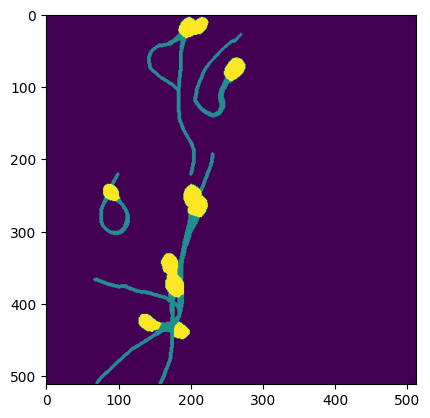

In [4]:
mask_to_display = true_masks[0]

# Przekształć maskę z formatu one-hot do formatu identyfikatorów klas
mask_to_display = np.argmax(mask_to_display, axis=0)

plt.imshow(mask_to_display)
plt.show()

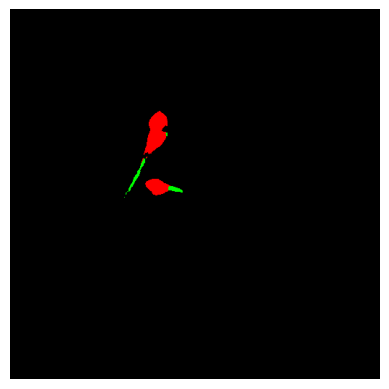

In [17]:
mask_to_display = predicted_masks[1]

# Przekształć maskę z formatu one-hot do formatu identyfikatorów klas
mask_to_display = np.argmax(mask_to_display, axis=0)

# Utwórz obraz RGB z maski
mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    mask_rgb[mask_to_display == i] = color

plt.imshow(mask_rgb)
plt.axis('off')
plt.show()

